In [4]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import zipfile
from scipy.stats import spearmanr

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from yellowbrick.model_selection import ValidationCurve, LearningCurve


In [5]:
# Download Data (using dataset from Kaggle for Kings County)
!kaggle datasets download -d harlfoxem/housesalesprediction



Dataset URL: https://www.kaggle.com/datasets/harlfoxem/housesalesprediction
License(s): CC0-1.0
housesalesprediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
with zipfile.ZipFile('housesalesprediction.zip', 'r') as zip_ref:
    zip_ref.extractall('housesalesprediction_data')

In [7]:
CSV_PATH = Path('housesalesprediction_data', 'kc_house_data.csv')

In [8]:
house_sales = pd.read_csv(CSV_PATH)
house_sales = house_sales.drop(['id', 'zipcode', 'lat', 'long', 'date'], axis=1)
house_sales.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   waterfront     21613 non-null  int64  
 7   view           21613 non-null  int64  
 8   condition      21613 non-null  int64  
 9   grade          21613 non-null  int64  
 10  sqft_above     21613 non-null  int64  
 11  sqft_basement  21613 non-null  int64  
 12  yr_built       21613 non-null  int64  
 13  yr_renovated   21613 non-null  int64  
 14  sqft_living15  21613 non-null  int64  
 15  sqft_lot15     21613 non-null  int64  
dtypes: float64(3), int64(13)
memory usage: 2.6 MB


#### Transforming, exploring and engineering features

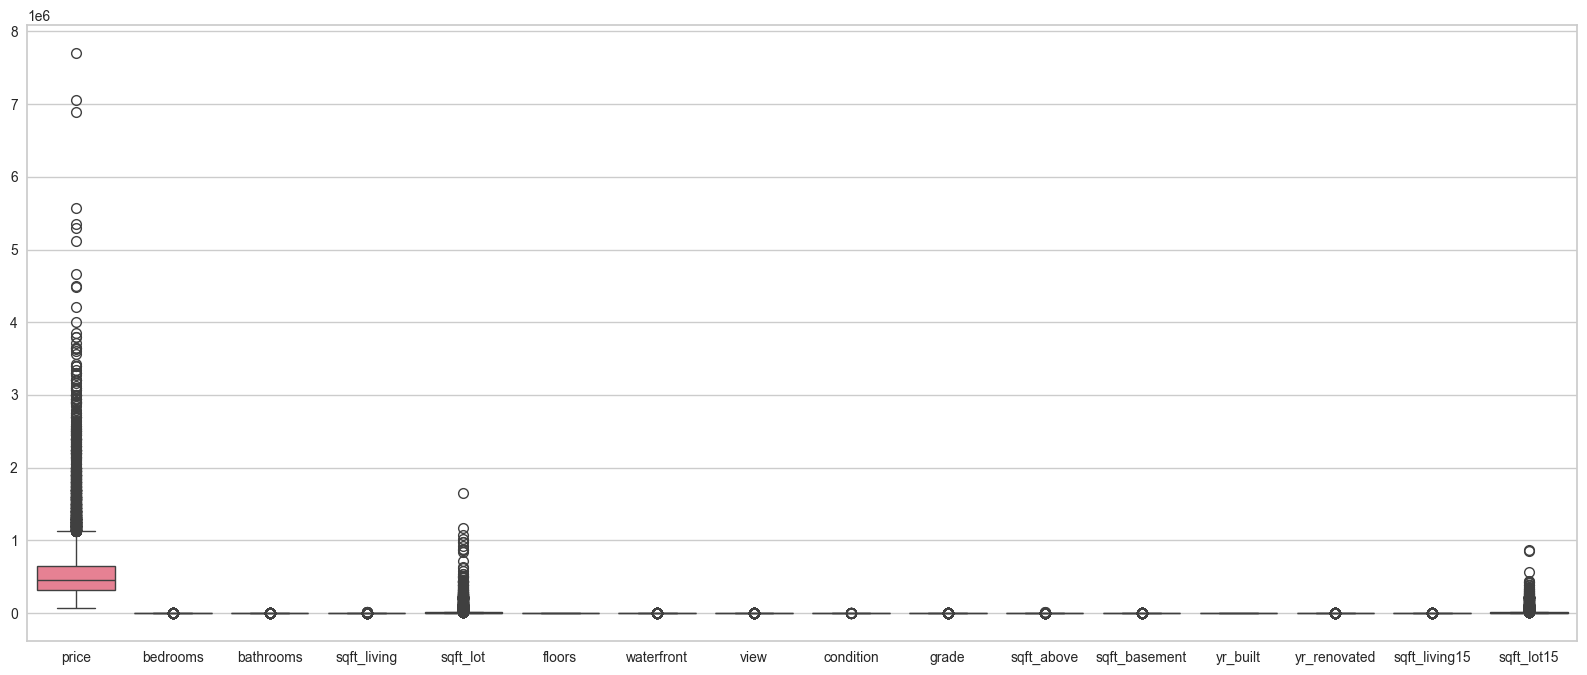

In [9]:
#We are trying to predict the prices column, based on the other data

plt.figure(figsize=(20,8))
sns.boxplot(data=house_sales);


<function matplotlib.pyplot.tight_layout(*, pad: 'float' = 1.08, h_pad: 'float | None' = None, w_pad: 'float | None' = None, rect: 'tuple[float, float, float, float] | None' = None) -> 'None'>

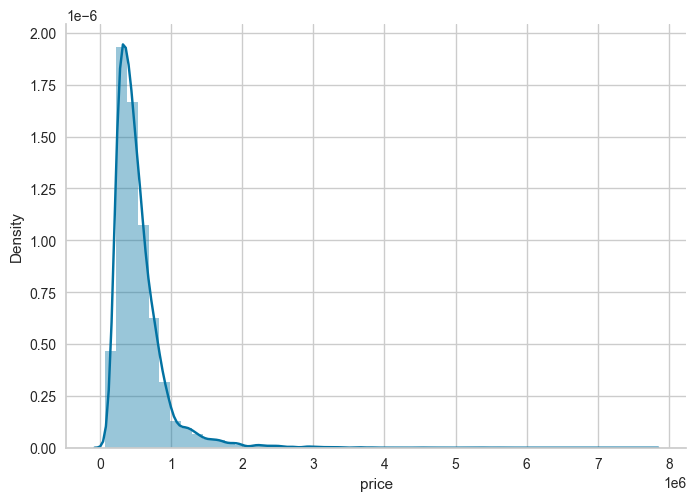

In [10]:
# Lots of crazy skew and outliers in the price column
#To better visualize the skew, will use a distplot
sns.distplot(house_sales['price'])
sns.despine()
plt.tight_layout

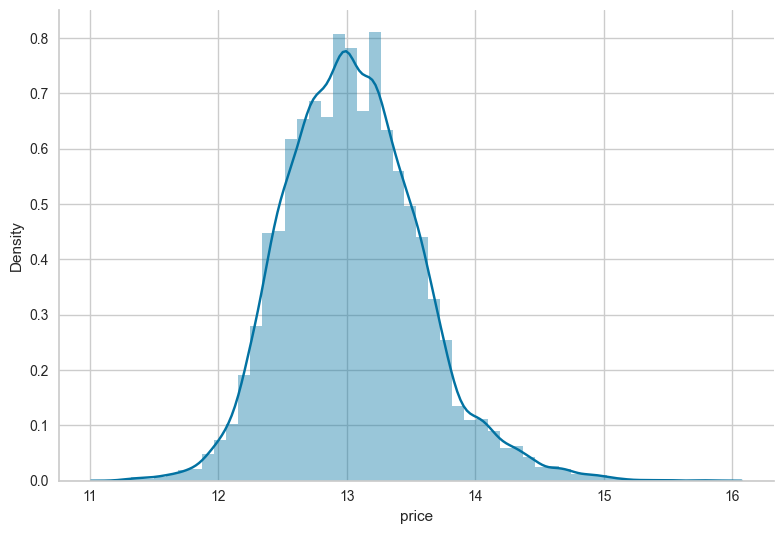

In [11]:
#We will use KNN, since its non-parametric it doesn't really care if the data is symmetric or not, but we will try to transform it to normality anyway.
#Looks kind of like an exponential distribution, so to fix it will try to do a log transform on it

X_all = house_sales.drop('price', axis=1)
y = np.log(house_sales['price'])
sns.distplot(y)
sns.despine()
plt.tight_layout()

<Axes: >

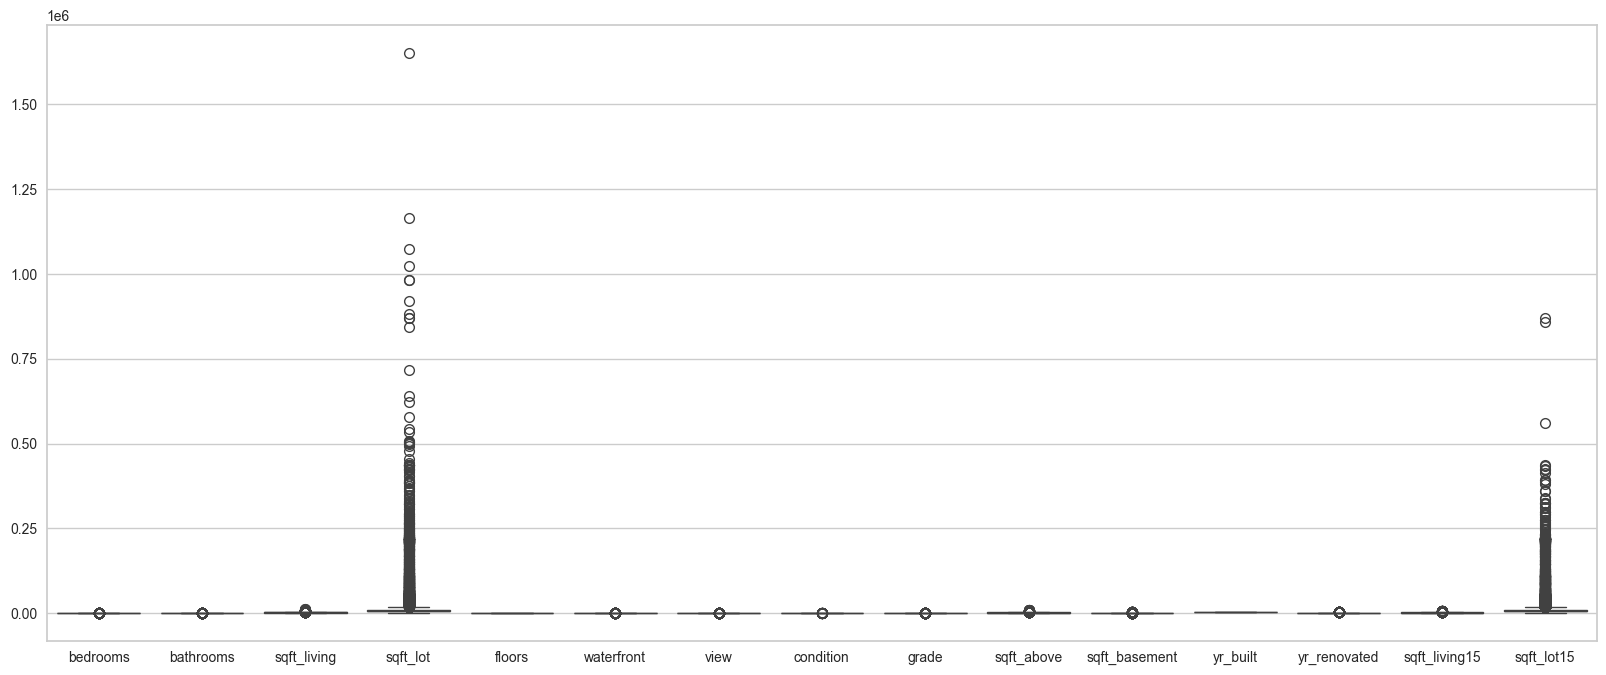

In [12]:
#Looks a lot more normal now.
plt.figure(figsize=(20,8))
sns.boxplot(data=X_all)

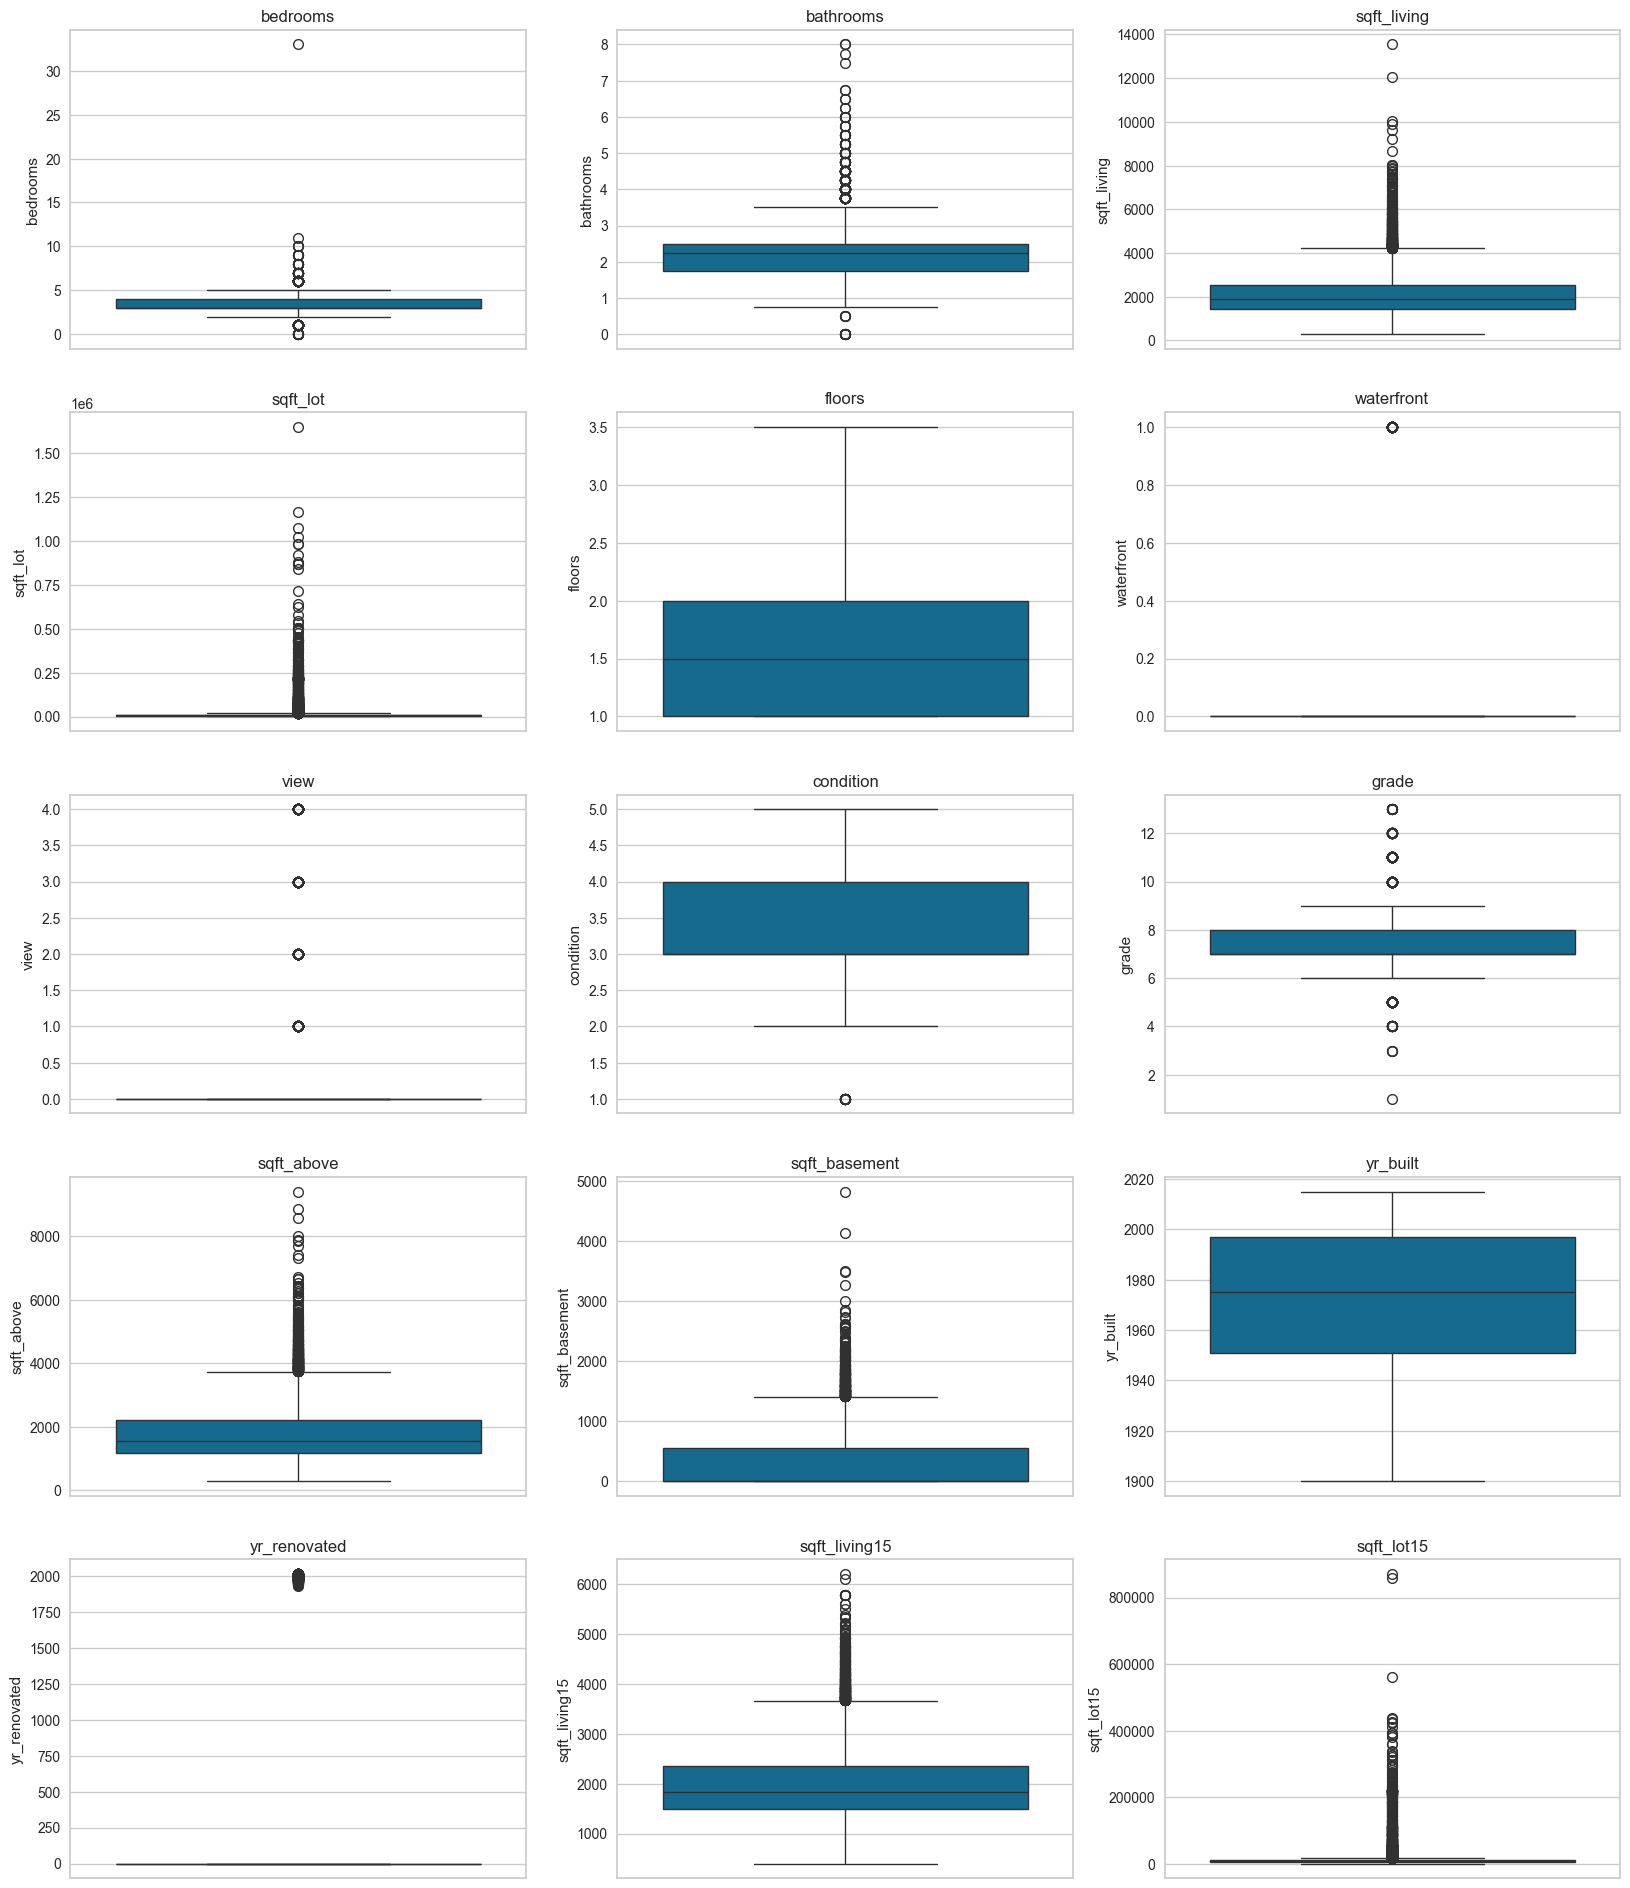

In [13]:
#Will plot each of the other features for inspection

fig, axes = plt.subplots(nrows=(len(X_all.columns)//3), ncols=3, figsize=(20, 24))
i = 0
for feature in X_all.columns:
    sns.boxplot(data=X_all[feature], ax=axes[i//3,i%3])
    axes[i//3, i%3].set_title(feature)
    i+=1

In [14]:
# I'll split the features into numerical and categorical
features_numeric = []
features_categorical = []

In [15]:
X_all['bedrooms'].value_counts()

bedrooms
3     9824
4     6882
2     2760
5     1601
6      272
1      199
7       38
0       13
8       13
9        6
10       3
11       1
33       1
Name: count, dtype: int64

In [16]:
#Why is there a house with 33 bedrooms? Let's check it out
X_all[X_all['bedrooms']==33]

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15
15870,33,1.75,1620,6000,1.0,0,0,5,7,1040,580,1947,0,1330,4700


In [17]:
#Must be a typo, 1.75 bathrooms, 33 bedrooms? Let's correct that to 3
X_all.loc[X_all['bedrooms']==33, 'bedrooms'] = 3
X_all[X_all['bedrooms']==11]

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15
8757,11,3.0,3000,4960,2.0,0,0,3,7,2400,600,1918,1999,1420,4960


In [18]:
#This one might be real. So let's add bedrooms to categorical (judgment call)
features_categorical.append('bedrooms')
X_all['bathrooms'].value_counts().sort_index()   

bathrooms
0.00      10
0.50       4
0.75      72
1.00    3852
1.25       9
1.50    1446
1.75    3048
2.00    1930
2.25    2047
2.50    5380
2.75    1185
3.00     753
3.25     589
3.50     731
3.75     155
4.00     136
4.25      79
4.50     100
4.75      23
5.00      21
5.25      13
5.50      10
5.75       4
6.00       6
6.25       2
6.50       2
6.75       2
7.50       1
7.75       1
8.00       2
Name: count, dtype: int64

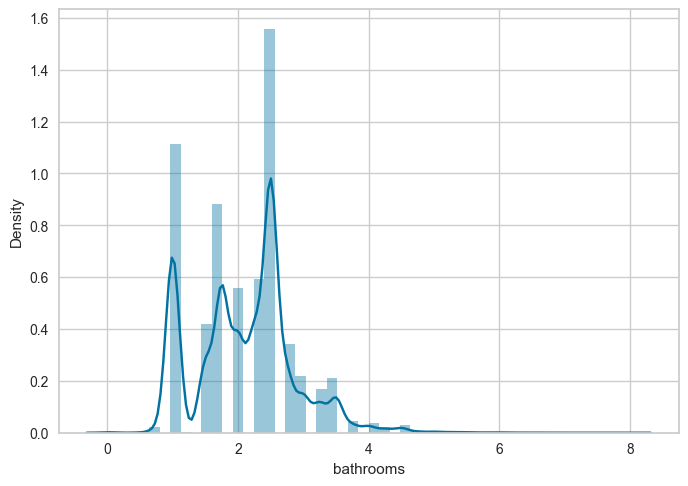

In [19]:
sns.distplot(X_all['bathrooms']);

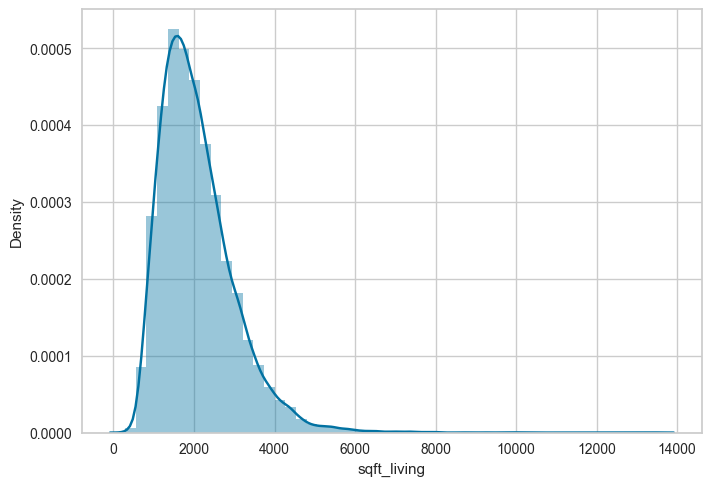

In [20]:
#I'll just treat it as numeric for now
features_numeric.append('bedrooms')
sns.distplot(X_all['sqft_living']);


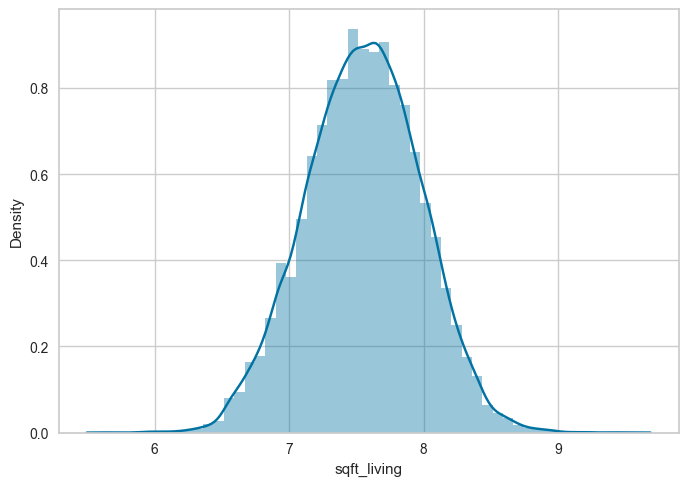

In [21]:
#I'll try to make it more normal with another log transform
X_all['sqft_living'] = np.log(X_all['sqft_living'])
sns.distplot(X_all['sqft_living']);

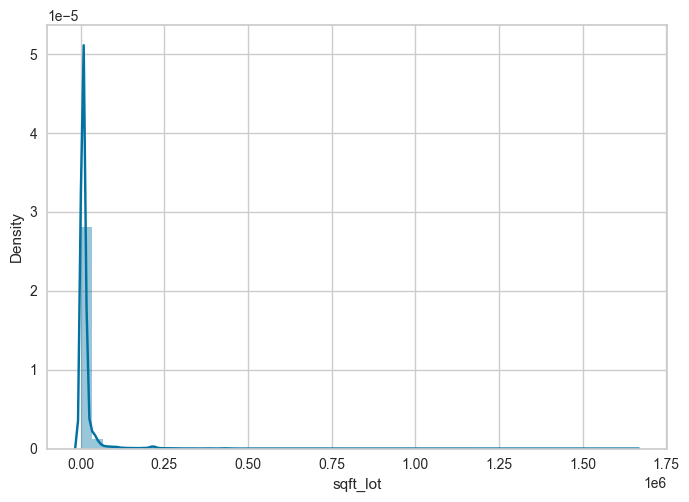

In [22]:
features_numeric.append('sqft_living')
sns.distplot(X_all['sqft_lot']);

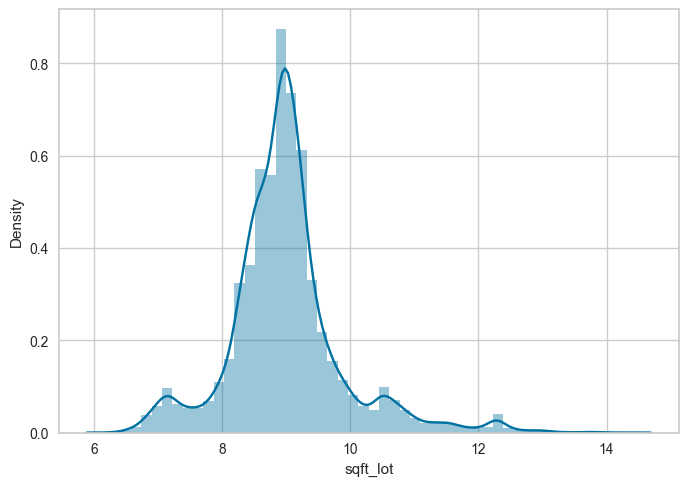

In [23]:
X_all['sqft_lot'] = np.log(X_all['sqft_lot'])
sns.distplot(X_all['sqft_lot']);

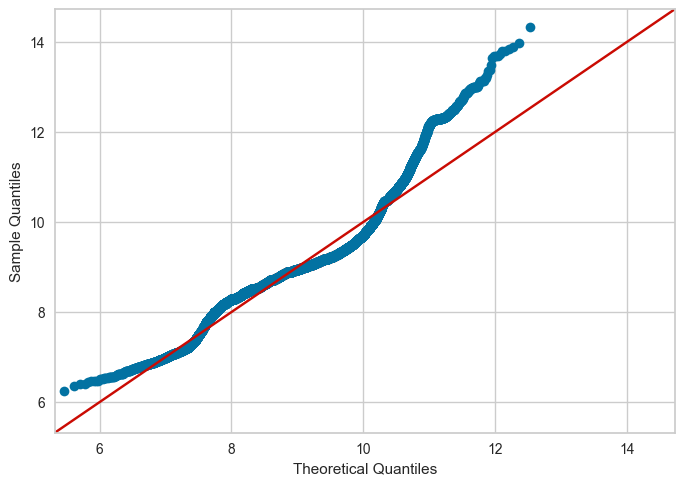

In [24]:
#Still looks weird, so from statsmodels.api I will use a qq plot to see how close it is to a normal distribution
import statsmodels.api as sm
sm.qqplot(X_all['sqft_lot'], loc=X_all['sqft_lot'].mean(), scale=X_all['sqft_lot'].std(), line='45');

In [25]:
#Looks normal enough so I'll just leave it
features_numeric.append('sqft_lot')
X_all['floors'].value_counts()

floors
1.0    10680
2.0     8241
1.5     1910
3.0      613
2.5      161
3.5        8
Name: count, dtype: int64

In [26]:
#What is half a floor? Tall walls? Looks ok so I'll just leave it
features_categorical.append('floors')
X_all['waterfront'].value_counts()

waterfront
0    21450
1      163
Name: count, dtype: int64

In [27]:
features_categorical.append('waterfront')
X_all['view'].value_counts()

view
0    19489
2      963
3      510
1      332
4      319
Name: count, dtype: int64

In [28]:
features_categorical.append('view')
X_all['condition'].value_counts()

condition
3    14031
4     5679
5     1701
2      172
1       30
Name: count, dtype: int64

In [29]:
features_categorical.append('condition')
X_all['grade'].value_counts()

grade
7     8981
8     6068
9     2615
6     2038
10    1134
11     399
5      242
12      90
4       29
13      13
3        3
1        1
Name: count, dtype: int64

<Axes: xlabel='sqft_above', ylabel='Density'>

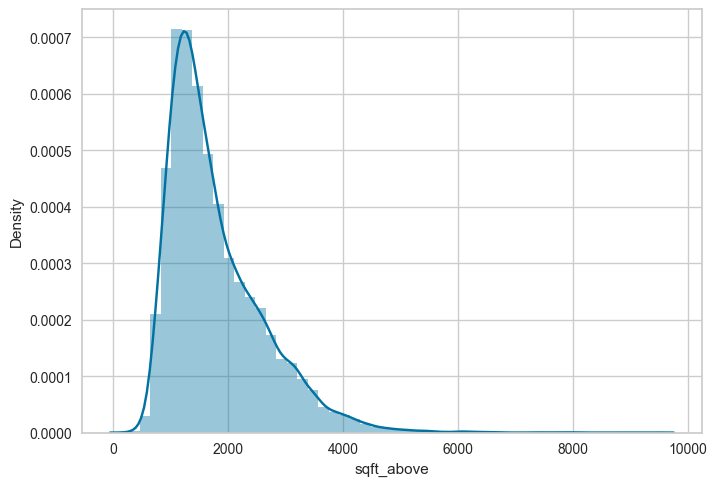

In [30]:
features_categorical.append('grade')
sns.distplot(X_all['sqft_above'])

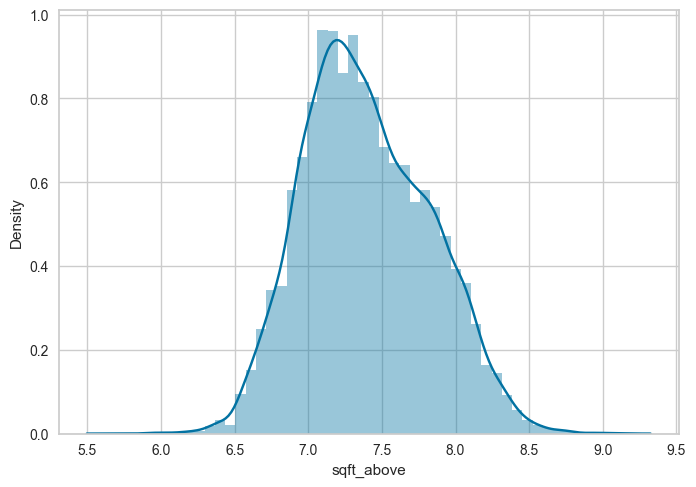

In [31]:
 X_all['sqft_above'] = np.log(X_all['sqft_above'])
sns.distplot(X_all['sqft_above']);

<Axes: xlabel='sqft_basement', ylabel='Density'>

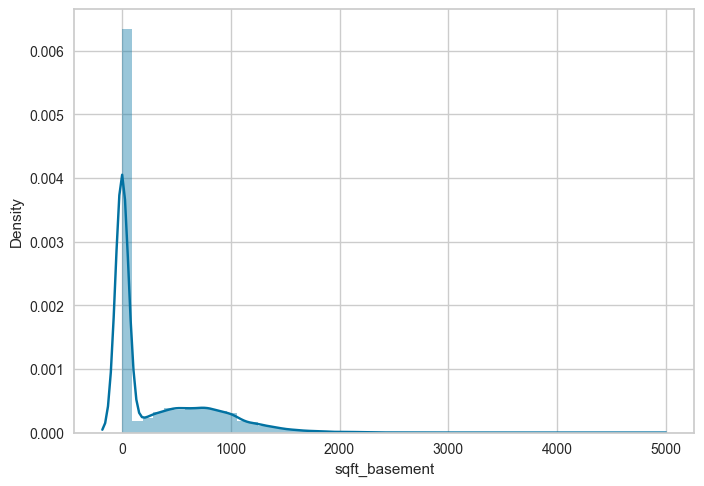

In [32]:
features_numeric.append('sqft_above')
sns.distplot(X_all['sqft_basement'])

In [33]:
#I decided since there are a lot of houses without a basement, I will just make this into a binary variable
X_all['has_basement'] = (X_all['sqft_basement'] > 0)*1
X_all['has_basement'].value_counts()

has_basement
0    13126
1     8487
Name: count, dtype: int64

In [34]:
#But I'll keep em both
features_categorical.append('has_basement')
features_numeric.append('sqft_basement')

<Axes: xlabel='yr_built', ylabel='Density'>

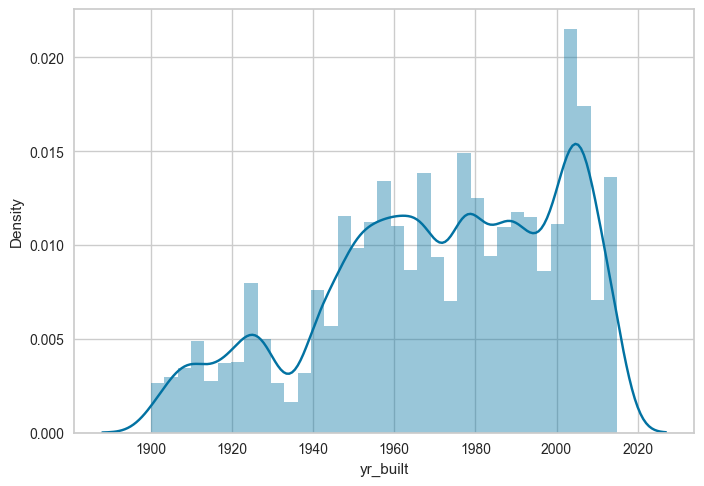

In [35]:
sns.distplot(X_all['yr_built'])

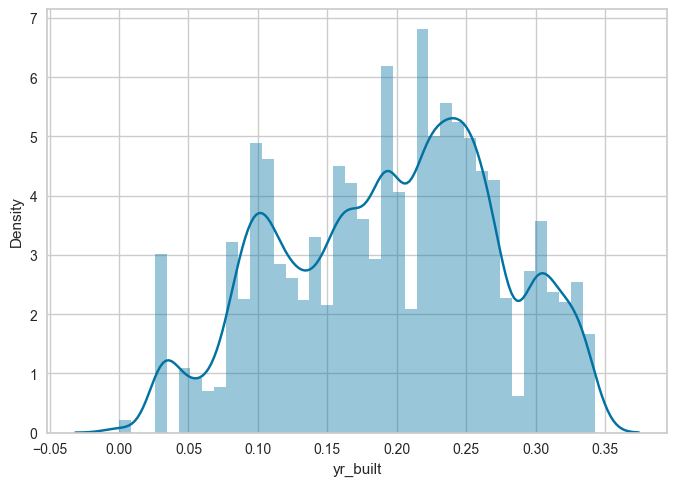

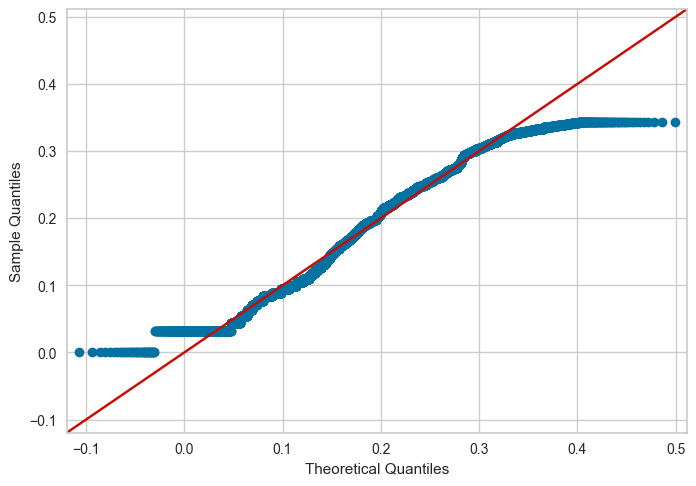

In [36]:
#I will try to make it more normal with a box-muller transformation (to turn a uniform random variable into a gaussian random variable)
#Need to have two uniform random variables ( so I'll create a new one u1)
u1 = (X_all['yr_built']) / (X_all['yr_built'].max())
test = np.sqrt(-2*np.log(u1)) * np.cos(-2*np.pi*X_all['yr_built'])
sns.distplot(test);
sm.qqplot(test, loc=test.mean(), scale=test.std(), line='45');

<Axes: xlabel='yr_renovated', ylabel='Density'>

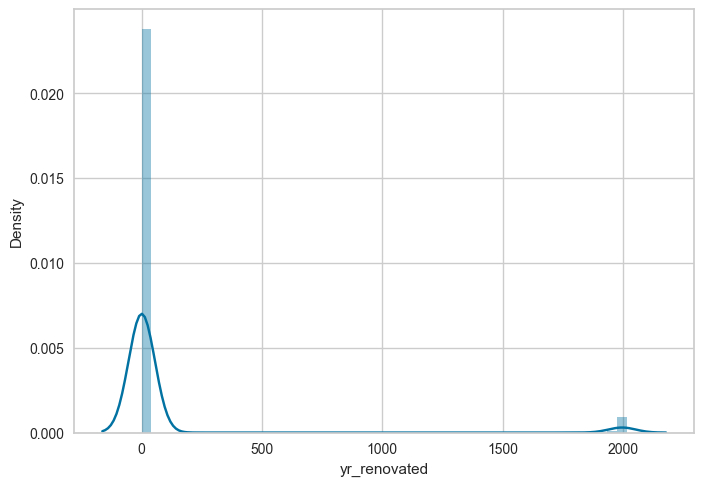

In [37]:
#It looks a lot better in the middle, I'll leave it for now.
features_numeric.append('yr_built')
sns.distplot(X_all['yr_renovated'])

In [38]:
#Obvious choice to make this one binary
X_all['yr_renovated'] = (X_all['yr_renovated'] > 0)*1
X_all['yr_renovated'].value_counts()

yr_renovated
0    20699
1      914
Name: count, dtype: int64

<Axes: xlabel='sqft_living15', ylabel='Density'>

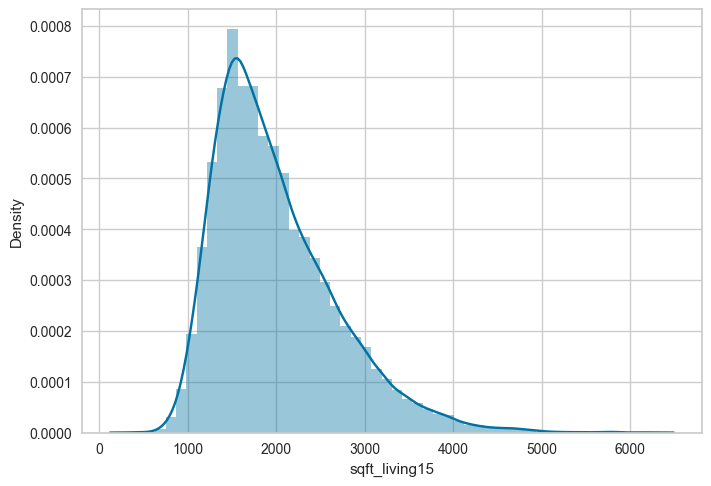

In [39]:
features_categorical.append('yr_renovated')
sns.distplot(X_all['sqft_living15'])

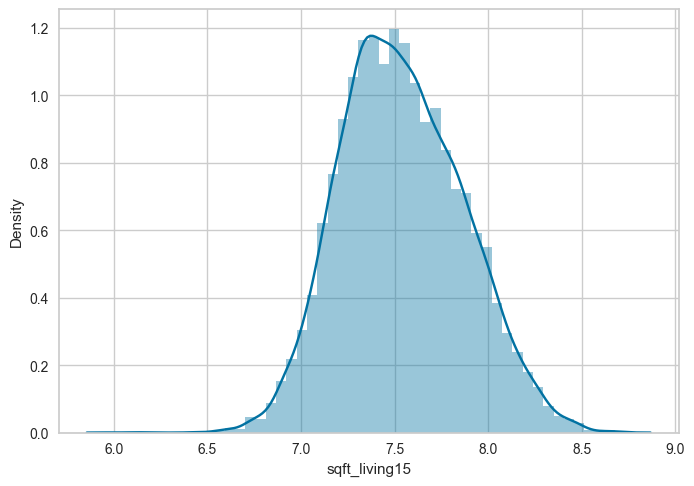

In [40]:
 X_all['sqft_living15'] = np.log(X_all['sqft_living15'])
sns.distplot(X_all['sqft_living15']);

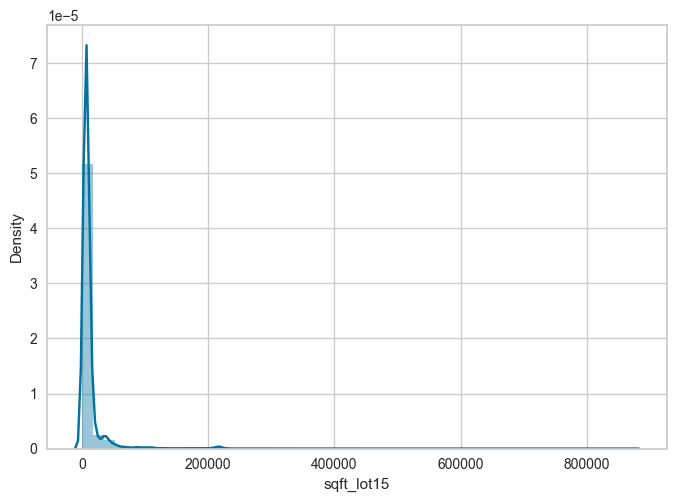

In [41]:
features_numeric.append('sqft_living15')
sns.distplot(X_all['sqft_lot15']);

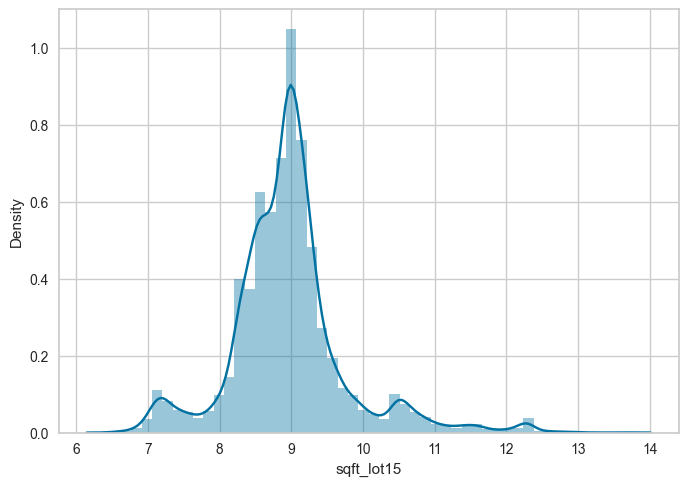

In [42]:
 X_all['sqft_lot15'] = np.log(X_all['sqft_lot15'])
sns.distplot(X_all['sqft_lot15']);

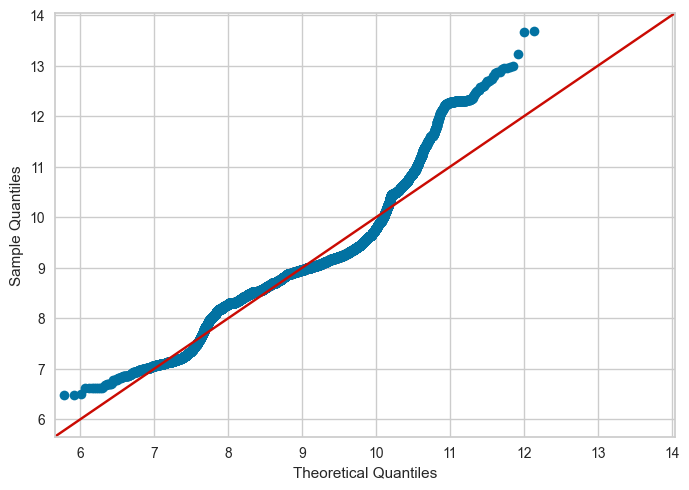

In [43]:
#Looks bumpy, lets check the qqplot
sm.qqplot(X_all['sqft_lot15'], loc=X_all['sqft_lot15'].mean(), scale=X_all['sqft_lot15'].std(), line='45');

In [44]:
#Close enough
features_numeric.append('sqft_lot15')

### Feature Encoding

In [45]:
from sklearn.preprocessing import OneHotEncoder

In [46]:
X_all[features_numeric].dtypes

bedrooms           int64
sqft_living      float64
sqft_lot         float64
sqft_above       float64
sqft_basement      int64
yr_built           int64
sqft_living15    float64
sqft_lot15       float64
dtype: object

In [47]:
for feature in features_numeric:
    X_all[feature] = X_all[feature].astype(float)

In [48]:
X_all[features_categorical].dtypes


bedrooms        float64
floors          float64
waterfront        int64
view              int64
condition         int64
grade             int64
has_basement      int32
yr_renovated      int32
dtype: object

In [49]:
X_all['floors'].value_counts()

floors
1.0    10680
2.0     8241
1.5     1910
3.0      613
2.5      161
3.5        8
Name: count, dtype: int64

In [50]:
#Will multiply this by 10 so that if changed into an integer, information is retained
X_all['floors'] = X_all['floors'] * 10
X_all['floors'].value_counts()

floors
10.0    10680
20.0     8241
15.0     1910
30.0      613
25.0      161
35.0        8
Name: count, dtype: int64

In [51]:
for feature in features_categorical:
    X_all[feature] = X_all[feature].astype(int)
X_all[features_categorical].dtypes

bedrooms        int32
floors          int32
waterfront      int32
view            int32
condition       int32
grade           int32
has_basement    int32
yr_renovated    int32
dtype: object

In [52]:
X_all['floors'].value_counts()

floors
10    10680
20     8241
15     1910
30      613
25      161
35        8
Name: count, dtype: int64

In [53]:
X_all.dtypes

bedrooms           int32
bathrooms        float64
sqft_living      float64
sqft_lot         float64
floors             int32
waterfront         int32
view               int32
condition          int32
grade              int32
sqft_above       float64
sqft_basement    float64
yr_built         float64
yr_renovated       int32
sqft_living15    float64
sqft_lot15       float64
has_basement       int32
dtype: object

In [54]:
#I would use one hot encoder if I was doing linear regression, but in this case we don't need it

##Mutual Information Regression
mi_reg = pd.Series(mutual_info_regression(X_all, y),
                   index=X_all.columns).sort_values(ascending=False)
mi_reg

sqft_living      0.351226
grade            0.345810
sqft_living15    0.271971
sqft_above       0.262415
bathrooms        0.205341
sqft_lot15       0.091908
floors           0.077278
bedrooms         0.076534
sqft_lot         0.073272
yr_built         0.073085
sqft_basement    0.069015
view             0.060577
has_basement     0.029309
waterfront       0.013049
yr_renovated     0.008553
condition        0.005989
dtype: float64

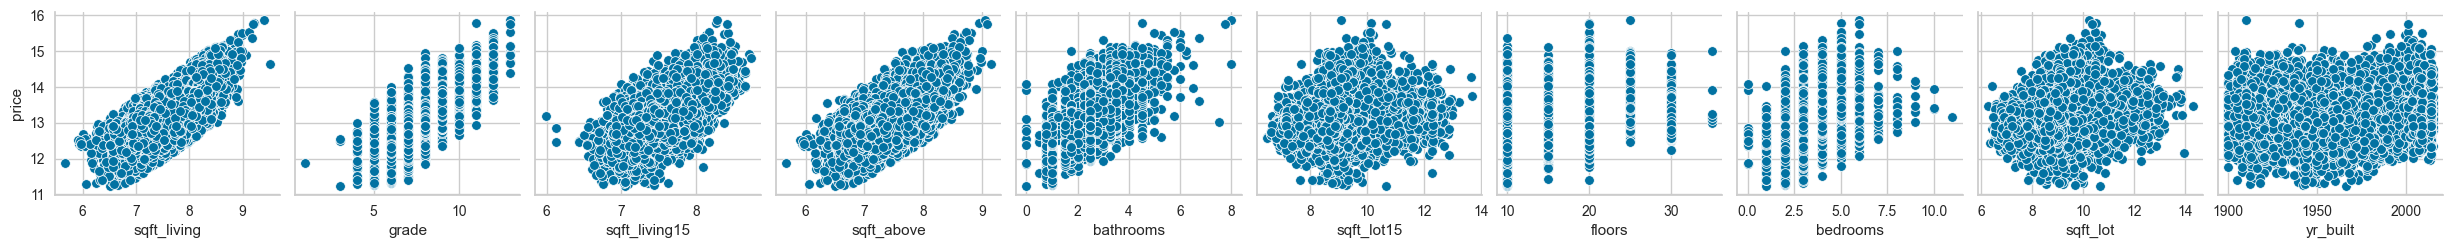

In [55]:
#keep the 10 highest-info factors
X= X_all.loc[:, mi_reg.iloc[:10].index]

#Scatterplots
pairs = sns.pairplot(X.assign(price=y), y_vars=['price'],
                     x_vars=X.columns)
sns.despine();

In [56]:
#Let's explore the feature correlation with target
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   sqft_living    21613 non-null  float64
 1   grade          21613 non-null  int32  
 2   sqft_living15  21613 non-null  float64
 3   sqft_above     21613 non-null  float64
 4   bathrooms      21613 non-null  float64
 5   sqft_lot15     21613 non-null  float64
 6   floors         21613 non-null  int32  
 7   bedrooms       21613 non-null  int32  
 8   sqft_lot       21613 non-null  float64
 9   yr_built       21613 non-null  float64
dtypes: float64(7), int32(3)
memory usage: 1.4 MB


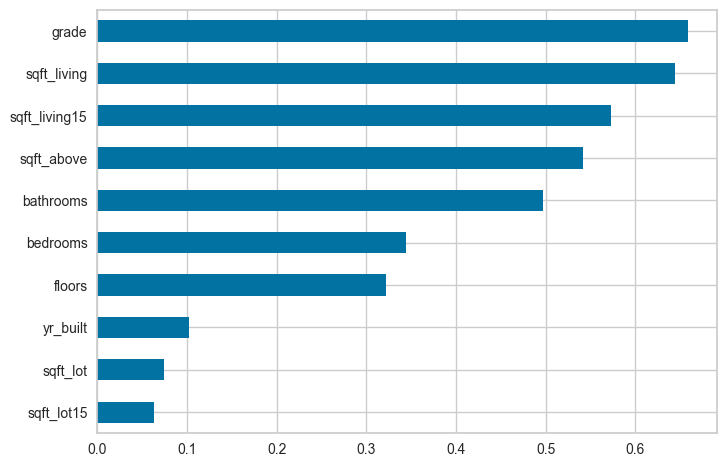

In [57]:
#Spearman correlation with Target
correlations = X.apply(lambda x: spearmanr(x, y)[0])
correlations.sort_values().plot.barh();

## KNN Regession

In [58]:
#In-Sample performance w/ Default hyperparameters

X_scaled = scale(X)

model = KNeighborsRegressor()
model.fit(X_scaled, y)

KNeighborsRegressor()

In [59]:
y_pred = model.predict(X_scaled)
y_pred[:10]

array([12.63373246, 13.32356286, 12.34365967, 12.96243048, 12.67290901,
       14.16071781, 12.59463358, 12.36698858, 12.59136251, 12.69134729])

### Regression Error Metrics

In [60]:
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error,
                             mean_squared_log_error,
                             median_absolute_error,
                             explained_variance_score,
                             r2_score)

In [61]:
## Prediction Error
error = (y - y_pred).rename('Prediction Error')

scores = dict(rmse=np.sqrt(mean_squared_error(y_true=y, y_pred=y_pred)),
              rmsle=np.sqrt(mean_squared_log_error(y_true=y, y_pred=y_pred)),
              mean_ae=mean_absolute_error(y_true=y, y_pred=y_pred),
              median_ae=median_absolute_error(y_true=y, y_pred=y_pred),
              r2score=r2_score(y_true=y, y_pred=y_pred))

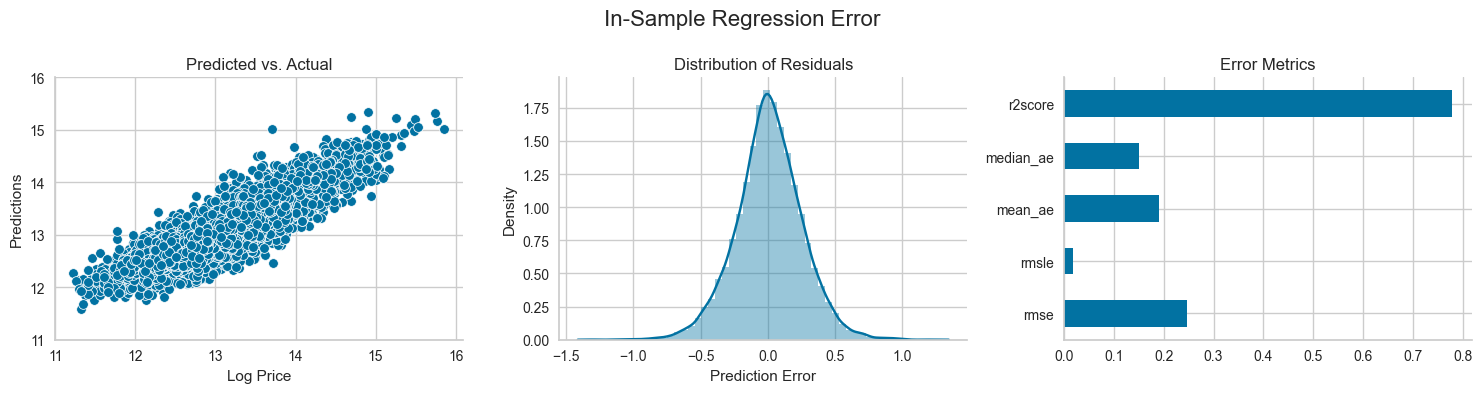

In [62]:
fig, axes = plt.subplots(ncols=3, figsize=(15,4))

sns.scatterplot(x=y, y=y_pred, ax=axes[0])
axes[0].set_xlabel('Log Price')
axes[0].set_ylabel('Predictions')
axes[0].set_ylim(11,16)
axes[0].set_title('Predicted vs. Actual')

sns.distplot(error, ax=axes[1])
axes[1].set_title('Distribution of Residuals')

pd.Series(scores).plot.barh(ax=axes[2], title='Error Metrics')

fig.suptitle('In-Sample Regression Error', fontsize=16)
plt.tight_layout()
sns.despine();

### Cross-Validation

I'll now do some manual hyperparameter tuning. I will use sklearn's pipeline function to ensure everything is handled the same way every time, with no data snooping.

KNN only has one hyperparameter; the number of nearest neighbors. 

In [63]:
#I will use RMSE as the model's score

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred))

rmse_score = make_scorer(rmse)

In [64]:
#Let's try changing the number of neighbors.
cv_rmse = {}
n_neighbors = [1] + list(range(5, 51, 5))
for n in n_neighbors:
    pipe = Pipeline([('scaler', StandardScaler()),
                      ('knn', KNeighborsRegressor(n_neighbors=n))])
    cv_rmse[n] = cross_val_score(pipe,
                                 X=X,
                                 y=y,
                                 scoring=rmse_score,
                                 cv=5)

In [65]:
cv_rmse = pd.DataFrame.from_dict(cv_rmse, orient='index')

In [66]:
best_n = cv_rmse.mean(1).idxmin()
best_rmse = cv_rmse.mean(1)[best_n]
print('Best K: ', best_n)
print('Best RMSE: ', round(best_rmse, 4))

Best K:  25
Best RMSE:  0.2967


In [67]:
#So the best value of neighbors was 25. Let's plot them
cv_rmse = cv_rmse.stack().reset_index()
cv_rmse.columns = ['n', 'fold', 'RMSE']

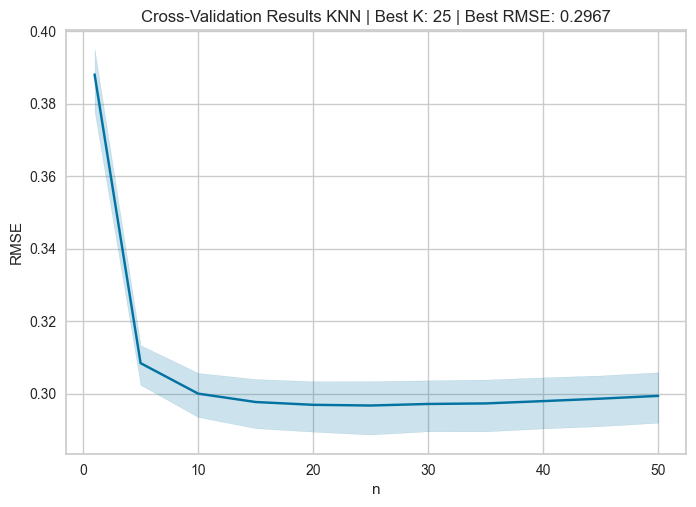

In [68]:
ax = sns.lineplot(x='n', y='RMSE', data=cv_rmse)
ax.set_title(f'Cross-Validation Results KNN | Best K: {best_n:d} | Best RMSE: {best_rmse:.4f}');

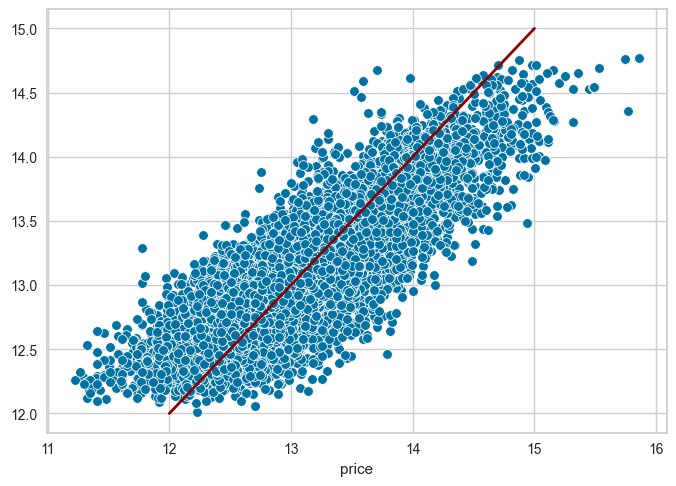

In [69]:
#25 does in fact look like about the minimum error.
pipe = Pipeline([('scaler', StandardScaler()),
                 ('knn', KNeighborsRegressor(n_neighbors=best_n))])
y_pred = cross_val_predict(pipe, X, y, cv=5)

ax = sns.scatterplot(x=y, y=y_pred)
y_range = list(range(int(y.min() + 1), int(y.max() + 1)))
pd.Series(y_range, index=y_range).plot(ax=ax, lw=2, c='darkred');
#We want to see a linear relationship

### Cross-Validation Error Metrics

In [70]:
error = (y - y_pred).rename('Prediction Errors')

scores = dict(rmse=np.sqrt(mean_squared_error(y_true=y, y_pred=y_pred)),
              rmsle=np.sqrt(mean_squared_log_error(y_true=y, y_pred=y_pred)),
              mean_ae=mean_absolute_error(y_true=y, y_pred=y_pred),
              median_ae=median_absolute_error(y_true=y, y_pred=y_pred),
              r2score=explained_variance_score(y_true=y, y_pred=y_pred))

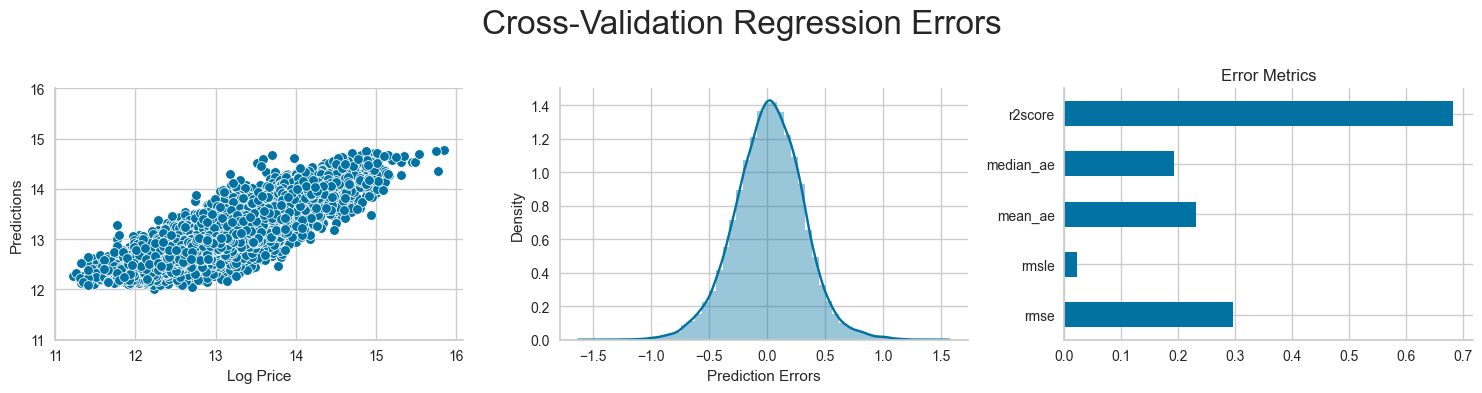

In [71]:
fig, axes = plt.subplots(ncols=3, figsize=(15,4))

sns.scatterplot(x=y, y=y_pred, ax=axes[0])
axes[0].set_xlabel('Log Price')
axes[0].set_ylabel('Predictions')
axes[0].set_ylim(11, 16)

sns.distplot(error, ax=axes[1])

pd.Series(scores).plot.barh(ax=axes[2], title='Error Metrics')

fig.suptitle('Cross-Validation Regression Errors', fontsize=24)
fig.tight_layout()
sns.despine();

### GridSearchCV w/ Pipeline

Similar to manual hyperparameter tuning, but slightly more automated

In [76]:
pipe = Pipeline([('scaler', StandardScaler()),
                 ('knn', KNeighborsRegressor())])

n_folds = 5
n_neighbors = tuple(range(5, 101, 5))

param_grid = {'knn__n_neighbors': n_neighbors}

estimator = GridSearchCV(estimator=pipe,
                         param_grid=param_grid,
                         cv=n_folds,
                         scoring=rmse_score)
estimator.fit(X,y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsRegressor())]),
             param_grid={'knn__n_neighbors': (5, 10, 15, 20, 25, 30, 35, 40, 45,
                                              50, 55, 60, 65, 70, 75, 80, 85,
                                              90, 95, 100)},
             scoring=make_scorer(rmse, response_method='predict'))

In [83]:
cv_results = estimator.cv_results_

test_scores = pd.DataFrame({fold: cv_results[f'split{fold}_test_score'] for fold in range(n_folds)},
                           index=n_neighbors).stack().reset_index()
test_scores.columns= ['k', 'fold', 'RMSE']

mean_rmse = test_scores.groupby('k').RMSE.mean()
best_k, best_score = mean_rmse.idxmin(), mean_rmse.min()

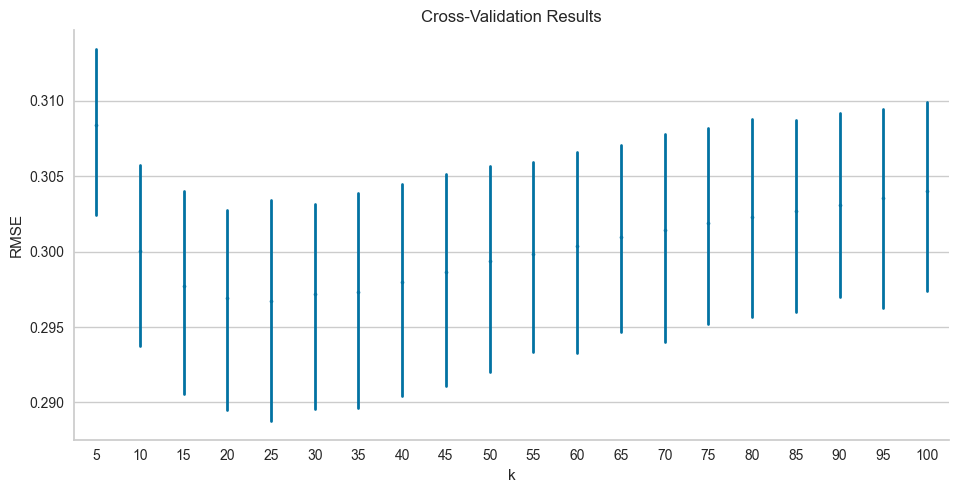

In [79]:
sns.pointplot(x='k', y='RMSE', data=test_scores, scale=0.3, join=False, errwidth=2)
plt.title('Cross-Validation Results')
sns.despine()
plt.tight_layout()
plt.gcf().set_size_inches(10,5);

### Training and Validation Curves w/ Yellowbricks

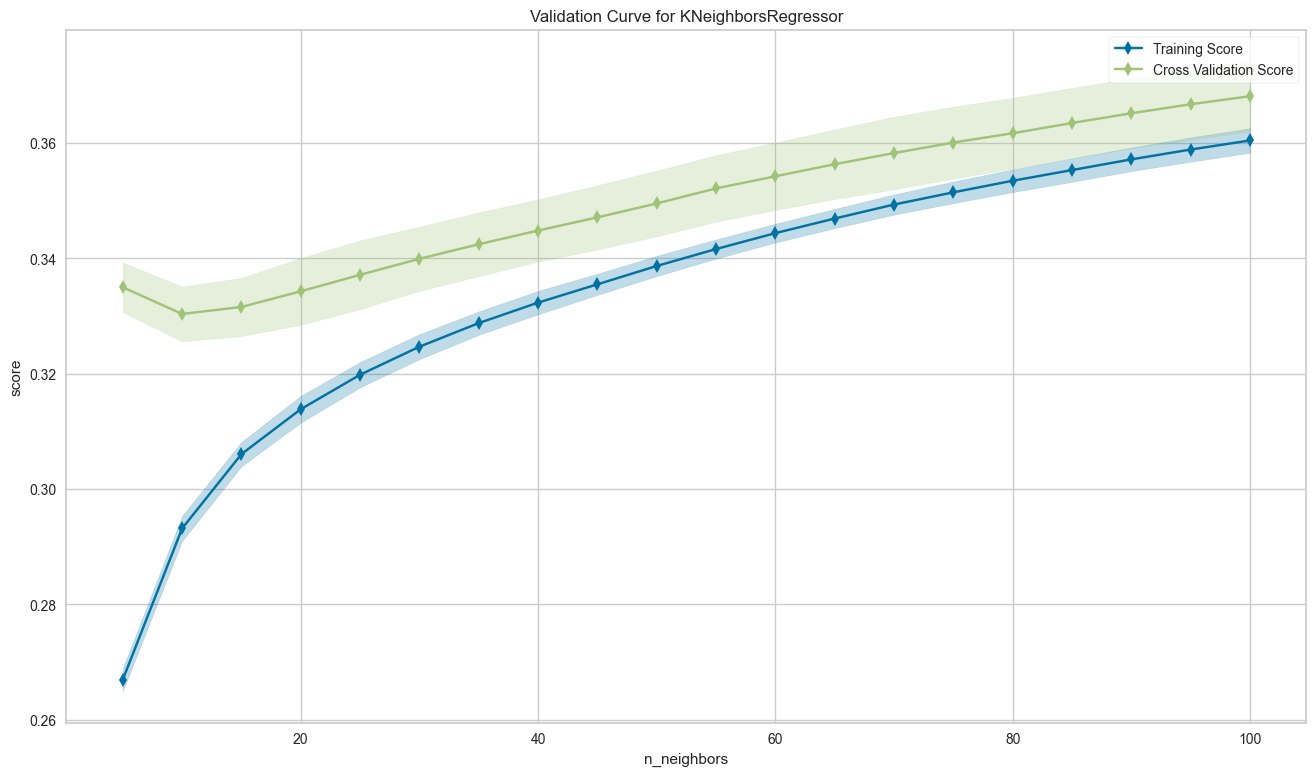

<Figure size 800x550 with 0 Axes>

In [81]:
fig, ax = plt.subplots(figsize=(16,9))
val_curve = ValidationCurve(KNeighborsRegressor(),
                            param_name='n_neighbors',
                            param_range=n_neighbors,
                            cv=5,
                            scoring=rmse_score,
                            ax=ax)
val_curve.fit(X, y)
val_curve.poof()
sns.despine()
fig.tight_layout();

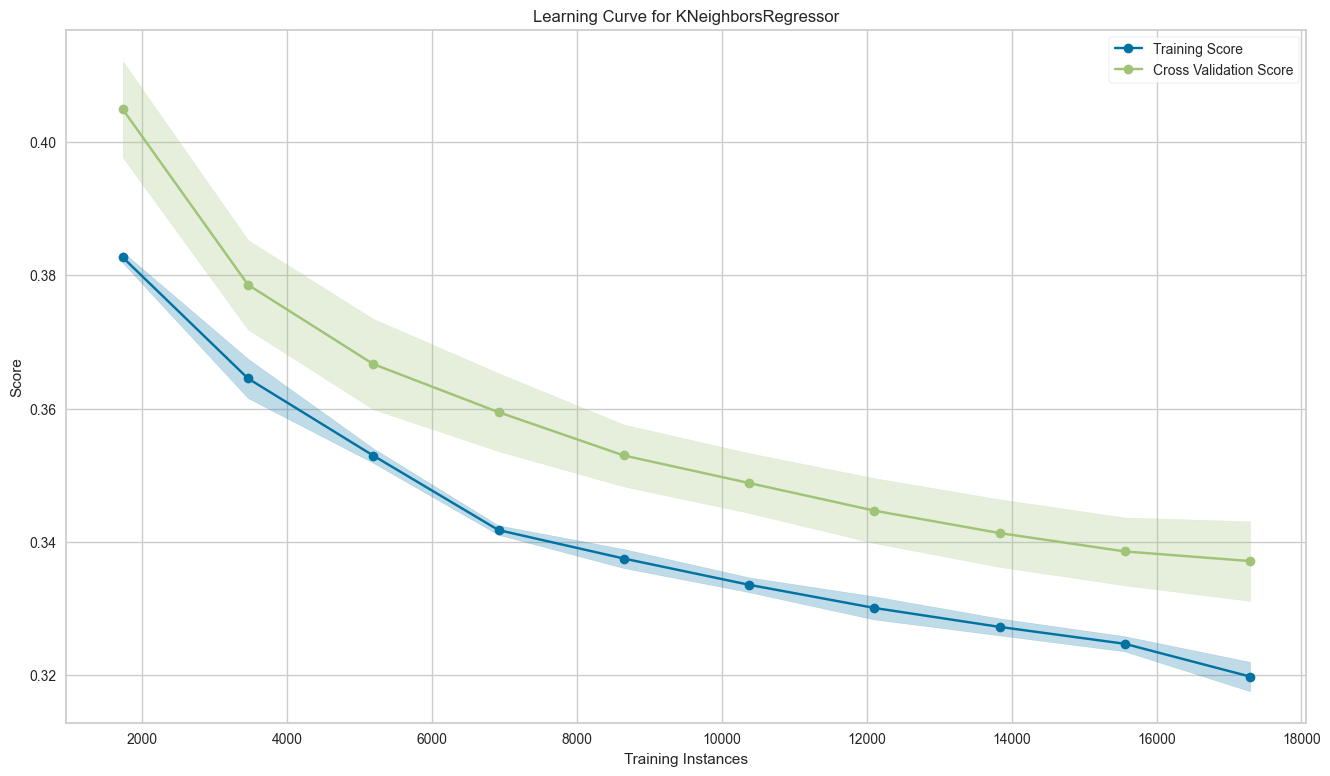

<Figure size 800x550 with 0 Axes>

In [84]:
fig, ax = plt.subplots(figsize=(16,9))
l_curve = LearningCurve(KNeighborsRegressor(n_neighbors=best_k),
                        train_sizes=np.arange(0.1, 1.01, 0.1),
                        scoring=rmse_score,
                        cv=5,
                        ax=ax)
l_curve.fit(X,y)
l_curve.poof()
sns.despine()
fig.tight_layout()

### KNN Classification
We will transform the dependent variable (y) to a binary variable where 1 represents a price above the median, and 0 represents a price below the median, then try using KNN to classify which houses are expected to sell above the median price.

In [85]:
y_binary = (y > y.median()).astype(int)

In [86]:
n_neighbors = tuple(range(5, 151, 10))
n_folds = 5
scoring = 'roc_auc'

In [87]:
pipe = Pipeline([('scaler', StandardScaler()),
                  ('knn', KNeighborsClassifier())])

param_grid = {'knn__n_neighbors' : n_neighbors}

estimator = GridSearchCV(estimator=pipe,
                         param_grid=param_grid,
                         cv=n_folds,
                         scoring=scoring)
estimator.fit(X, y_binary)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__n_neighbors': (5, 15, 25, 35, 45, 55, 65, 75, 85,
                                              95, 105, 115, 125, 135, 145)},
             scoring='roc_auc')

In [88]:
best_k = estimator.best_params_['knn__n_neighbors']

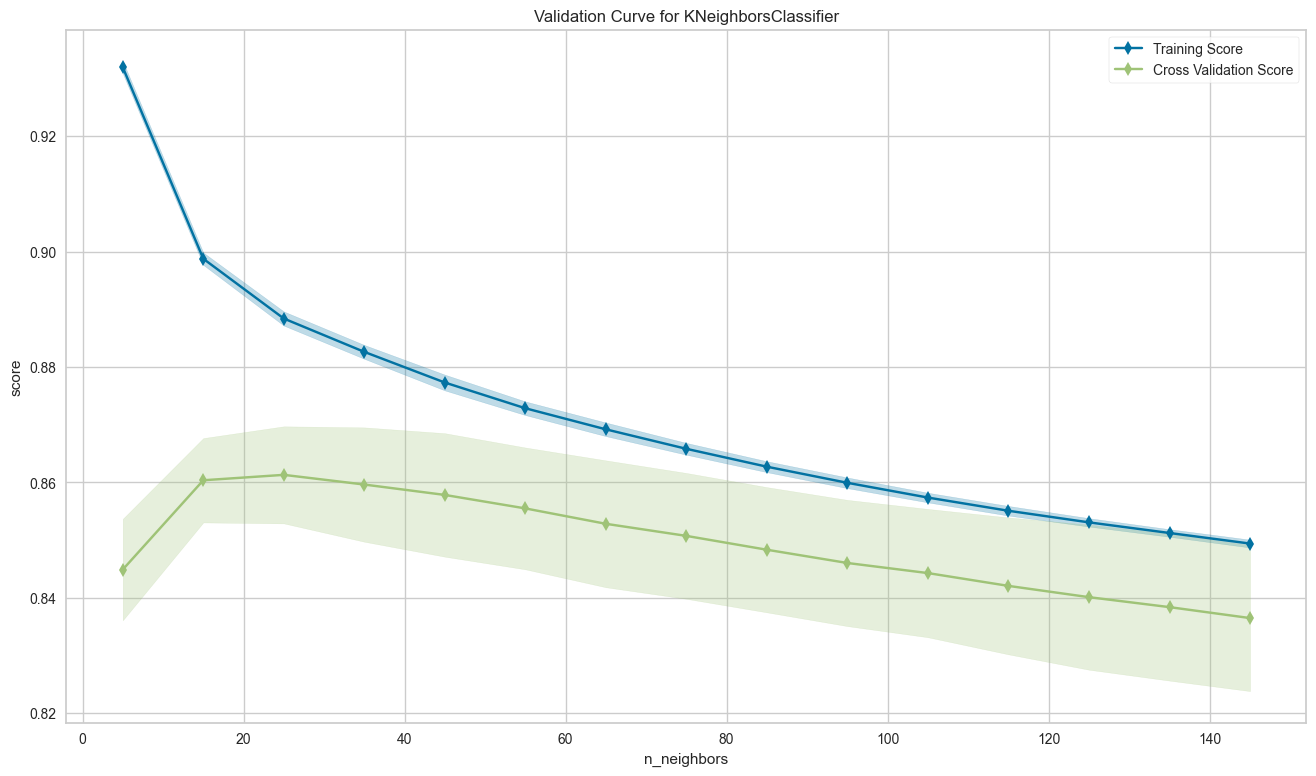

<Figure size 800x550 with 0 Axes>

In [90]:
fig, ax = plt.subplots(figsize=(16,9))
val_curve = ValidationCurve(KNeighborsClassifier(),
                            param_name='n_neighbors',
                            param_range=n_neighbors,
                            cv=n_folds,
                            scoring=scoring,
                            ax=ax)
val_curve.fit(X, y_binary)
val_curve.poof()
plt.tight_layout()
sns.despine();

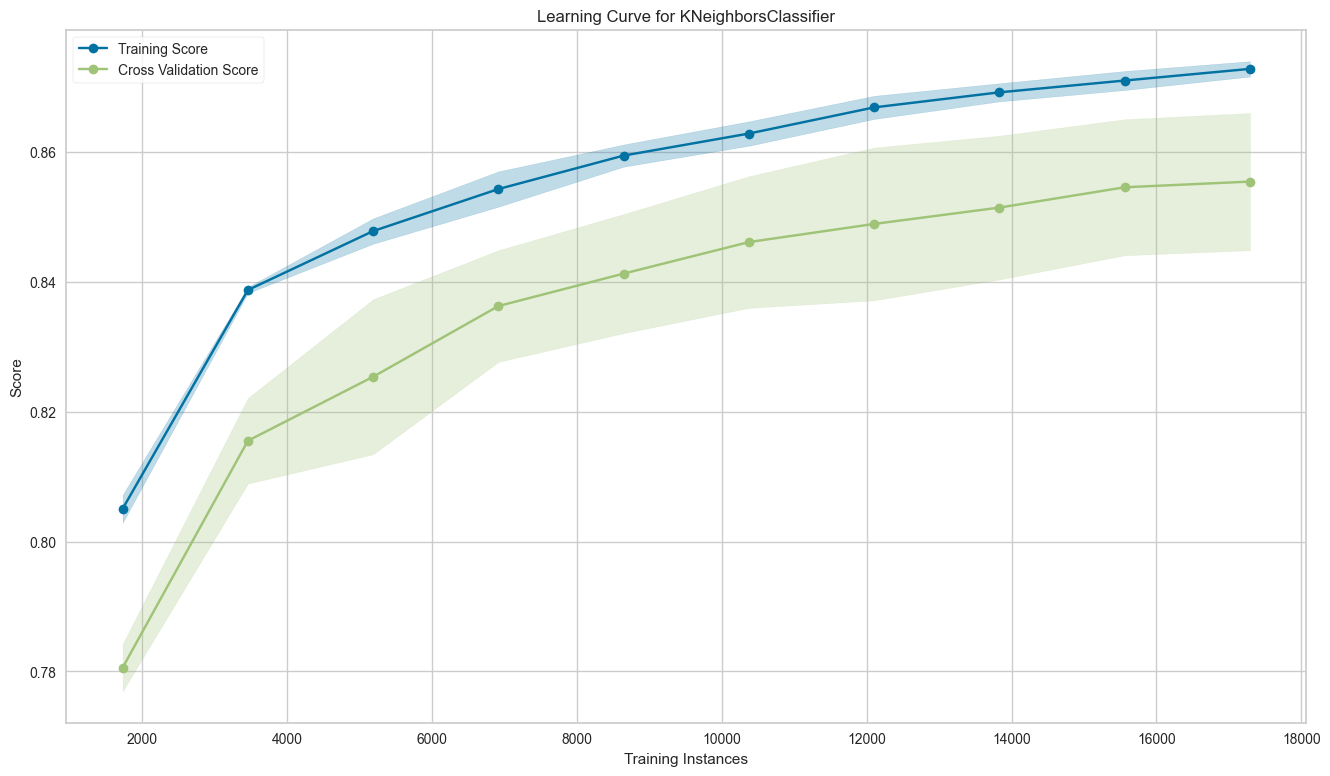

<Figure size 800x550 with 0 Axes>

In [92]:
fig, ax = plt.subplots(figsize=(16,9))
l_curve = LearningCurve(KNeighborsClassifier(n_neighbors=best_k),
                          train_sizes=np.arange(0.1, 1.01, 0.1),
                            scoring=scoring,
                            cv=5,
                            ax=ax)
l_curve.fit(X, y_binary)
l_curve.poof()
plt.tight_layout()
sns.despine();

### Classification Error Metrics

In [93]:
from sklearn.metrics import (classification_report,
                             accuracy_score,
                             zero_one_loss,
                             roc_auc_score,
                             roc_curve,
                             brier_score_loss,
                             cohen_kappa_score,
                             confusion_matrix,
                             fbeta_score,
                            hamming_loss,
                            hinge_loss,
                            jaccard_score,
                            log_loss,
                            matthews_corrcoef,
                            f1_score,
                            average_precision_score,
                            precision_recall_curve)

In [94]:
y_score = cross_val_predict(KNeighborsClassifier(best_k),
                            X=X,
                            y=y_binary,
                            cv=5,
                            n_jobs=-1,
                            method='predict_proba')[:, 1]

In [95]:
pred_scores = dict(y_true=y_binary, y_score=y_score)

In [96]:
roc_auc_score(**pred_scores)

0.8543429982732236

In [97]:
# ROC Curve
cols = ['False Positive Rate', 'True Positive Rate', 'threshold']
roc = pd.DataFrame(dict(zip(cols, roc_curve(**pred_scores))))

In [98]:
# Precision-Recall Curve
precision, recall, ts = precision_recall_curve(y_true=y_binary, probas_pred=y_score)
pr_curve = pd.DataFrame({'Precision': precision,
                         'Recall' : recall})

In [99]:
# F1 Score
f1 = pd.Series({t: f1_score(y_true=y_binary, y_pred=y_score>t) for t in ts})
best_threshold = f1.idxmax()
best_threshold

0.38181818181818183

In [100]:
#Let's start plotting some of this stuff.
roc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57 entries, 0 to 56
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   False Positive Rate  57 non-null     float64
 1   True Positive Rate   57 non-null     float64
 2   threshold            57 non-null     float64
dtypes: float64(3)
memory usage: 1.5 KB


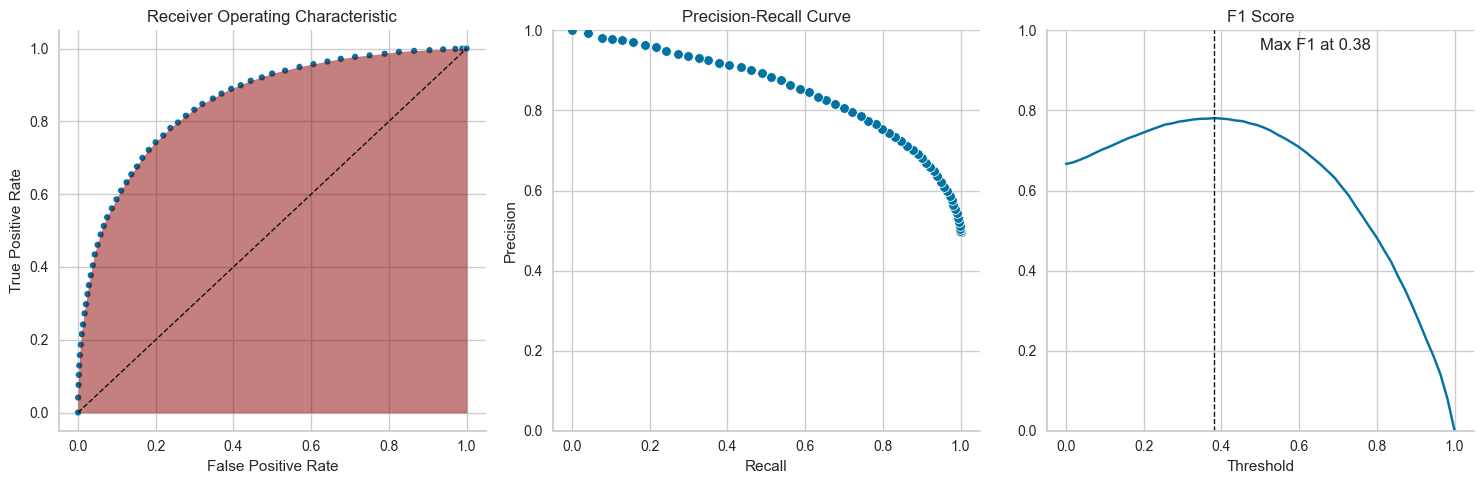

In [101]:
fig, axes = plt.subplots(ncols=3, figsize=(15,5))
ax = sns.scatterplot(x='False Positive Rate', y='True Positive Rate', data=roc,
                     size=5, legend=False, ax=axes[0])

axes[0].plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100),
             color='k', ls='--', lw=1)
axes[0].fill_between(y1=roc['True Positive Rate'],
                     x=roc['False Positive Rate'],
                     alpha=0.5, color='darkred')
axes[0].set_title('Receiver Operating Characteristic')

sns.scatterplot(x='Recall', y='Precision', data=pr_curve, ax=axes[1])
axes[1].set_ylim(0, 1)
axes[1].set_title('Precision-Recall Curve')

f1.plot(ax=axes[2], title='F1 Score', ylim=(0,1))
axes[2].set_xlabel('Threshold')
axes[2].axvline(best_threshold, lw=1, ls='--', color='k')
axes[2].text(s=f'Max F1 at {best_threshold:.2f}', x=0.5, y =0.95)

fig.tight_layout()
sns.despine();

In [103]:
## Average Precision
average_precision_score(y_true=y_binary, y_score=y_score)
pr_curve

,Precision,Recall
0,0.497340,1.000000
1,0.499977,0.999721
2,0.504392,0.998977
3,0.512348,0.997860
4,0.521335,0.995721
5,0.531999,0.993767
6,0.542828,0.991069
7,0.552756,0.985952
8,0.564087,0.981394
9,0.575522,0.977300


In [104]:
## Brier Score
brier_score_loss(y_true=y_binary, y_prob=y_score)

0.1565622618465394

In [105]:
# Predictions AFTER setting threshold
y_pred = y_score > best_threshold
scores = dict(y_true=y_binary, y_pred=y_pred)

In [106]:
#F-beta Score
fbeta_score(**scores, beta=1)

0.7809580940954666

In [107]:
# Classification Report
print(classification_report(**scores))

              precision    recall  f1-score   support

           0       0.82      0.68      0.74     10864
           1       0.72      0.85      0.78     10749

    accuracy                           0.76     21613
   macro avg       0.77      0.76      0.76     21613
weighted avg       0.77      0.76      0.76     21613



In [108]:
# Accuracy
accuracy_score(**scores)

0.7634756859297644

In [109]:
# Zero-One Loss
zero_one_loss(**scores)

0.23652431407023555

In [110]:
# Hamming Loss
hamming_loss(**scores)

0.2365243140702355

In [111]:
# Cohen's Kappa
cohen_kappa_score(y1=y_binary, y2=y_pred)

0.5273661845729132

In [112]:
# Hinge Loss
hinge_loss(y_true=y_binary, pred_decision=y_pred)

0.7391847499190302

In [113]:
# Jaccard Similarity
jaccard_score(**scores)

0.6406326889279438

In [114]:
# Log Loss (Cross Entropy)
log_loss(**scores)

8.525200394446253

In [115]:
# Matthews Correlation Coefficient
matthews_corrcoef(**scores)

0.5351669941922628

### Multi-Class Classification

In [116]:
#To make it multi-class, will cut it into three 'quintiles'
y_multi = pd.qcut(y, q=3, labels=[0,1,2])
np.unique(y_multi, return_counts=True)

(array([0, 1, 2], dtype=int64), array([7226, 7223, 7164], dtype=int64))

In [117]:
n_neighbors = tuple(range(5, 151, 10))
n_folds = 5
scoring = 'accuracy'

In [118]:
pipe = Pipeline([('scaler', StandardScaler()),
                  ('knn', KNeighborsClassifier())])

param_grid = {'knn__n_neighbors': n_neighbors}

estimator = GridSearchCV(estimator=pipe,
                         param_grid=param_grid,
                         cv=n_folds,
                         n_jobs=-1)
estimator.fit(X, y_multi)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': (5, 15, 25, 35, 45, 55, 65, 75, 85,
                                              95, 105, 115, 125, 135, 145)})

In [119]:
y_pred = cross_val_predict(estimator.best_estimator_,
                           X=X,
                           y=y_multi,cv=5,
                           n_jobs=-1,
                           method='predict')

In [120]:
print(classification_report(y_true=y_multi, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.68      0.73      0.70      7226
           1       0.54      0.52      0.53      7223
           2       0.78      0.75      0.76      7164

    accuracy                           0.67     21613
   macro avg       0.67      0.67      0.67     21613
weighted avg       0.67      0.67      0.67     21613



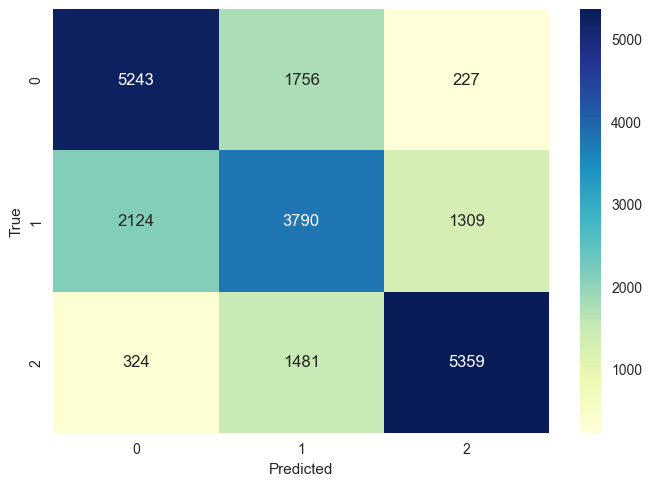

In [123]:
fig = sns.heatmap(confusion_matrix(y_true=y_multi, y_pred=y_pred),
                  annot=True, cmap='YlGnBu', fmt='g')
fig.set_xlabel('Predicted')
fig.set_ylabel('True');

In [ ]:
# We see that it had a hard time with predicting the ones in the middle